## Code Setup

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import birdmaps.bird_runs
import scgt

In [6]:
FILE_PATH = "/Users/luca/Library/CloudStorage/GoogleDrive-luca@ucsc.edu/Shared drives/Birds and CS/Data/CA-Luca"
bird_run = birdmaps.bird_runs.BirdRun(FILE_PATH)

In [7]:
# We define the transmission exponent for the runs.
# This defines how to merge (improve) the terrain transmission according to
# ebird data.
RUN_NAME = "CA"

In [8]:
acowoo_run = bird_run.get_bird_run("acowoo", "Acorn Woodpecker", run_name=RUN_NAME)
stejay_run = bird_run.get_bird_run("stejay", "Steller's Jay", run_name=RUN_NAME)
birds = [acowoo_run, stejay_run]


In [9]:
# Reads the set of terrain types that appear. 
terrain = scgt.GeoTiff.from_file(acowoo_run.terrain_fn)
tile = terrain.get_all_as_tile()
terrain_types = sorted(list(np.unique(tile.m)))

In [10]:
import csv, json

def read_resistance_csv(fn):
    """Reads a dictionary of terrain to resistance in csv, producing a dictionary."""
    d = {}
    with open(fn) as f:
        reader = csv.DictReader(f)
        for row in reader:
            d[int(row['map_code'])] = float(row['resistance'])
    return d

def write_transmission_csv(resistance, fn):
    """
    :resistance: a dictionary mapping map codes (integers) to resistance values (float)"""
    with open(fn, "w") as f:
        writer = csv.DictWriter(f, fieldnames=['map_code', 'transmission'])
        writer.writeheader()
        for k, v in resistance.items():
            writer.writerow({'map_code': k, 'transmission': v})

def plot_histogram(d, title=""):
    xs = list(d.keys())
    xs.sort(reverse=True)
    sxs = [str(x) for x in xs]
    ys = [d[x] for x in xs]
    plt.barh(sxs, ys, label=sxs)
    plt.title(title)
    plt.show()

In [11]:
# See https://docs.google.com/spreadsheets/d/13pFa8tlHpjWYT0t_HHOE7LoZPoOPaBvO/edit#gid=1586882738
def resistance_generic_terrain(t):
    if 100 <= t < 200:
        return 0 # Forest
    elif 200 <= t < 300:
        return 0.4 # Savanna
    elif 300 <= t < 400:
        return 0.2 # Shrubland
    elif 400 <= t < 500: 
        return 0.2 # Grassland
    elif 500 <= t < 600:
        return 0.3 # Wetlands
    elif 600 <= t < 700: 
        return 0.3 # Rocky
    elif 700 <= t < 800:
        return 0.4 # Caves
    elif 800 <= t < 900:
        return 0.4 # Desert
    elif t == 1401:
        return 0.6
    elif t == 1402: 
        return 0. # This is very good territory for flyover. 
    elif t in [1403, 1404]:
        return 0.2
    elif t == 1405: # Urban
        return 0.6
    elif t == 1406:
        return 0
    elif 1507 <= t <= 1510:
        return 0.6 
    elif t == 1600:
        return 0.2
    else:
        return 1.

In [12]:
def merge_transmission_forest_birds(resistance_d):
    """Merges the resistance histogram with the observation dictionary."""
    # These are all the terrains.
    # I initialize the transmission using the resistance dictionary.
    transmission = {}
    for t in terrain_types:
        # Computes the resistance. 
        r = min(resistance_d.get(t, 1.), resistance_generic_terrain(t))
        transmission[t] = 1 - r
    return transmission


In [13]:
from collections import defaultdict
import matplotlib

matplotlib.rc('figure', figsize=(8, 8))

def compute_transmission(bird, show=False, use_generic=True):
    """Diagnoses the terrain for a bird, and computes the transmission"""
    resistance_d = read_resistance_csv(bird.resistance_original_fn)
    transmission = merge_transmission_forest_birds(resistance_d)
    write_transmission_csv(transmission, bird.transmission_fn)
    print("Wrote", bird.transmission_fn)
    if show:
        plot_histogram(resistance_d, title="{} original resistance".format(bird.name))
        plot_histogram(transmission, title="{} transmission".format(bird.name))
    print("Done", bird.name)

Wrote /Users/luca/Library/CloudStorage/GoogleDrive-luca@ucsc.edu/Shared drives/Birds and CS/Data/CA-Luca/acowoo/transmission_refined_1.csv


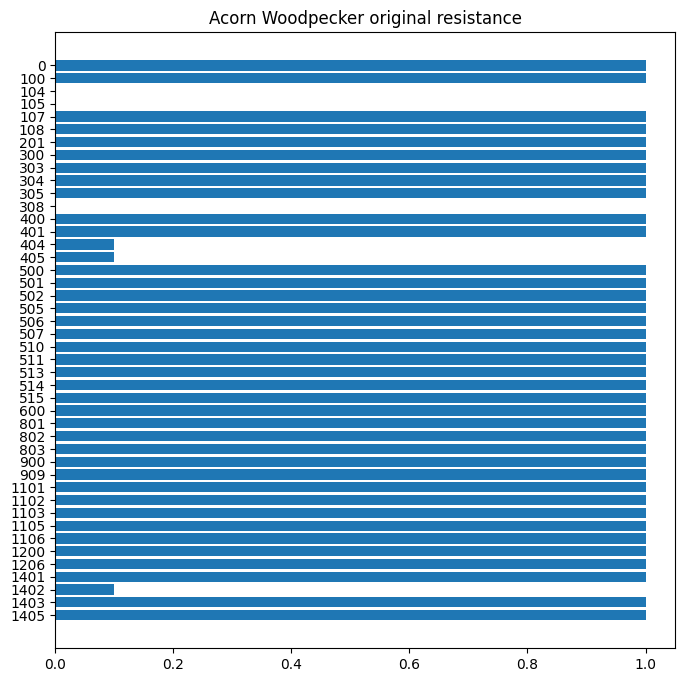

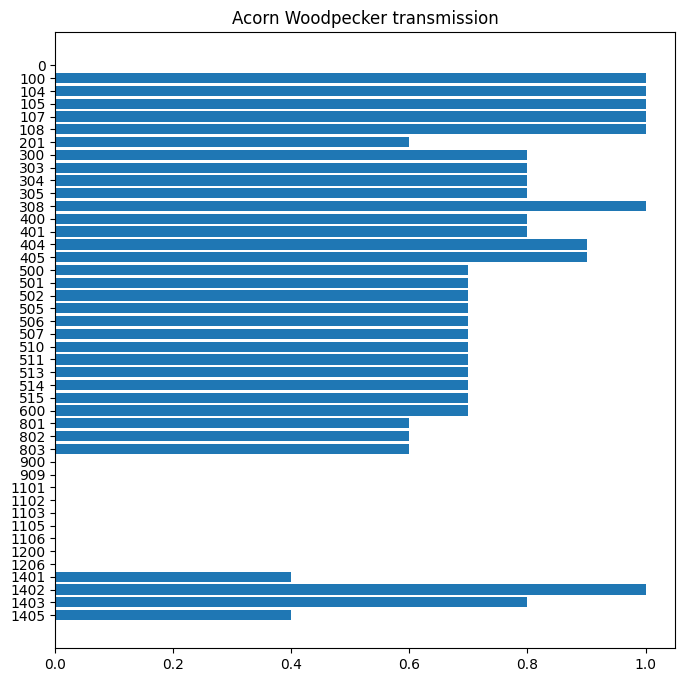

Done Acorn Woodpecker


In [15]:
compute_transmission(acowoo_run, show=True)

In [16]:
for b in birds:
    compute_transmission(b)

Wrote /Users/luca/Library/CloudStorage/GoogleDrive-luca@ucsc.edu/Shared drives/Birds and CS/Data/CA-Luca/acowoo/transmission_refined_1.csv
Done Acorn Woodpecker
Wrote /Users/luca/Library/CloudStorage/GoogleDrive-luca@ucsc.edu/Shared drives/Birds and CS/Data/CA-Luca/stejay/transmission_refined_1.csv
Done Steller's Jay
